<a href="https://colab.research.google.com/github/nishidatakeshi/AIQuest_PBL01/blob/main/PBL01_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PBL01_需要予測・在庫最適化　サンプルコード

## 目次
1. データの読み込み
2. 前処理
3. 特徴量生成
4. モデリング
5. 提出用ファイルの作成

なお、ソースコードは配布ファイルがすべて同じディレクトリ内に存在することを想定しています。

# ライブラリのインポート

In [ ]:
from itertools import product

import pandas as pd
import numpy as np
from datetime import datetime as dt

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from fbprophet import Prophet

import lightgbm as lgb
# import optuna.integration.lightgbm as lgb

import time

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
  
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import gc
from sklearn import preprocessing, metrics

# 1.データの読み込み
pandas.read_csv()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sales = pd.read_csv('drive/MyDrive/AIQuest/sales_history.csv')
cats = pd.read_csv('drive/MyDrive/AIQuest/item_categories.csv')
cat_names = pd.read_csv('drive/MyDrive/AIQuest/category_names.csv')
test = pd.read_csv('drive/MyDrive/AIQuest/test.csv')
sub = pd.read_csv('drive/MyDrive/AIQuest/sample_submission.csv', header=None)

sales = sales.rename(columns={'日付': 'date', "店舗ID": "shop_id","商品ID": "item_id", "商品価格":"item_price", "売上個数":"item_cnt_day"})
cats = cats.rename(columns={'商品カテゴリID': 'item_category_id', "商品ID": "item_id"})
cat_names = cat_names.rename(columns={'商品カテゴリID': 'item_category_id', "商品カテゴリ名": "item_category_name"})
test = test.rename(columns={'商品ID':'item_id', '店舗ID':'shop_id'})

# 2.前処理

### 「年」「月」の情報を抽出
pandas.Series.apply(), str.split()

In [ ]:
# 「date」カラムの文字列から、「年」「月」の情報を抽出する
sales['year'] = sales['date'].apply(lambda x: x.split('-')[0])
sales['month'] = sales['date'].apply(lambda x: x.split('-')[1])

sales.head()

,date,shop_id,item_id,item_price,item_cnt_day,year,month
0,2018-01-01,9,1000001,420,1.0,2018,01
1,2018-01-01,6,1000001,420,1.0,2018,01
2,2018-01-01,10,1000001,420,1.0,2018,01
3,2018-01-01,0,1000017,250,1.0,2018,01
4,2018-01-01,1,1000017,250,1.0,2018,01


予測するべきべき170商品のうち、今年から販売が開始された20商品とそれ以前から販売されている150商品に分ける。

In [ ]:
sales['date'] = sales['date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
# 予測対象の商品データ(170商品)
target_items = test["item_id"].unique()
target_sales = sales[sales["item_id"].isin(target_items)]
target_sales = target_sales.reset_index(drop=True)

# 予測対象のうち昨年販売実績のある商品データ(150商品)
target_items_150 = target_sales[target_sales["date"] < dt(2019, 1, 1)]["item_id"].unique()
target_sales_150 = target_sales[target_sales["item_id"].isin(target_items_150)]
target_sales_150 = target_sales_150.reset_index(drop=True)

# 予測対象のうち今年のみ販売実績のある商品データ(20商品)
target_items_20 = list(set(target_items) - set(target_items_150))
target_sales_20 = target_sales[target_sales["item_id"].isin(target_items_20)]
target_sales_20 = target_sales_20.reset_index(drop=True)

### 「date_block_num」通し番号作成

In [ ]:
# カラム名「date_block_num」として、通し番号をつける
gp_time = sales.groupby(['year', 'month']).count().reset_index()[['year', 'month']]
gp_time['date_block_num'] = list(range(len(gp_time)))

# testデータ用に、評価対象期間である2019年12月(date_block_num: 23)のレコードを追加する
gp_time = gp_time.append({
    'date_block_num': 23,
    'year': '2019',
    'month': '12'
}, ignore_index=True)

gp_time

,year,month,date_block_num
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4
5,2018,06,5
6,2018,07,6
7,2018,08,7
8,2018,09,8
9,2018,10,9


In [ ]:
# 「date_block_num」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['year', 'month'], how='left')
sales

,date,shop_id,item_id,item_price,item_cnt_day,year,month,date_block_num
0,2018-01-01,9,1000001,420,1.0,2018,01,0
1,2018-01-01,6,1000001,420,1.0,2018,01,0
2,2018-01-01,10,1000001,420,1.0,2018,01,0
3,2018-01-01,0,1000017,250,1.0,2018,01,0
4,2018-01-01,1,1000017,250,1.0,2018,01,0
...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,2019,10,21
1119566,2019-10-31,7,3400009,1020,1.0,2019,10,21
1119567,2019-10-31,7,3400012,510,1.0,2019,10,21
1119568,2019-10-31,4,3500001,340,1.0,2019,10,21


### 全組み合わせを作成


In [ ]:
matrix = []

columns = ['date_block_num', 'item_id', 'shop_id']

for i in range(22):
    train_block = sales[sales['date_block_num']==i]
    matrix.append(np.array(list(product([i], train_block['item_id'].unique(), train_block['shop_id'].unique()))))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=columns)
matrix.sort_values(columns, inplace=True)

### 月毎の売上個数を集計、追加
pandas.DataFrame.groupby()

In [ ]:
cols = ['date_block_num','shop_id','item_id']

In [ ]:
group = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

### testデータにカラムを追加する

In [ ]:
new_test = test.copy()

# 評価対象期間が2019年12月(date_block_num: 23)であるという情報を追加
new_test['date_block_num'] = 23

new_test.head()

,index,item_id,shop_id,date_block_num
0,0,1000001,0,23
1,1,1000001,1,23
2,2,1000001,2,23
3,3,1000001,3,23
4,4,1000001,4,23


### 外れ値を探す

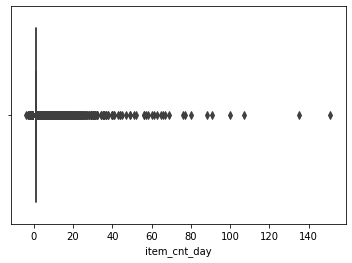

In [ ]:
sns.boxplot(x=sales.item_cnt_day)

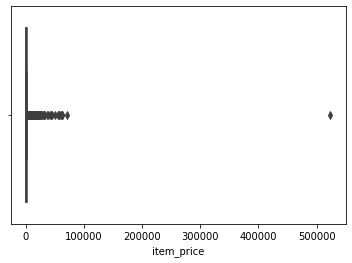

In [ ]:
sns.boxplot(x=sales.item_price)

In [ ]:
sales = sales[(sales.item_price < 100000) & (sales.item_price > 0)]

### 学習データとテストデータを縦に結合
pd.concat()

In [ ]:
matrix = pd.concat([matrix, new_test])
matrix

,date_block_num,item_id,shop_id,item_cnt_month,index
0,0,1000001,0,6.0,NaN
1,0,1000001,1,2.0,NaN
2,0,1000001,2,1.0,NaN
3,0,1000001,3,2.0,NaN
4,0,1000001,4,0.0,NaN
...,...,...,...,...,...
3055,23,3500001,13,NaN,3055.0
3056,23,3500001,14,NaN,3056.0
3057,23,3500001,15,NaN,3057.0
3058,23,3500001,16,NaN,3058.0


### 商品カテゴリIDを追加

In [ ]:
matrix = pd.merge(matrix, cats, on='item_id', how='left')

# 3.特徴量作成

### ラグ特徴量の作成
lag_feature(dataset, どれだけずらすか(配列), どのカラムを対象にするか):

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

売上個数(2,3,6,12)

In [ ]:
matrix = lag_feature(matrix, [2,3,6,12], 'item_cnt_month')

月売上個数平均

In [ ]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [2], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

商品別月売上個数平均

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

店舗別月売上個数平均

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

商品カテゴリ別月売上個数平均

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [2], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

商品カテゴリ別店舗別月別売上個数平均

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [2], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

商品平均価格

In [ ]:
ts = time.time()
group = sales.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

31.62816882133484

###「月」情報の追加

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12 + 1

### 欠損値を0で埋める

In [ ]:
matrix = matrix.fillna(0)

In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651986 entries, 0 to 1651985
Data columns (total 23 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   date_block_num                    1651986 non-null  int64  
 1   item_id                           1651986 non-null  int64  
 2   shop_id                           1651986 non-null  int64  
 3   item_cnt_month                    1651986 non-null  float16
 4   index                             1651986 non-null  float64
 5   item_category_id                  1651986 non-null  int64  
 6   item_cnt_month_lag_2              1651986 non-null  float16
 7   item_cnt_month_lag_3              1651986 non-null  float16
 8   item_cnt_month_lag_6              1651986 non-null  float16
 9   item_cnt_month_lag_12             1651986 non-null  float16
 10  date_avg_item_cnt_lag_2           1651986 non-null  float16
 11  date_item_avg_item_cnt_lag_2      165

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del group
del sales
del cat_names
del cats
# leave test for submission

# 4. モデリング

In [ ]:
data = pd.read_pickle('data.pkl')

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    # 'item_id',
    'item_cnt_month',
    'item_category_id',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_2',
    'date_shop_cat_avg_item_cnt_lag_2',
    'delta_price_lag',
    'month',
]]

In [ ]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
data = data[data['date_block_num'] >= 12]

# X_train = data[data['date_block_num'] < 21].drop(['item_cnt_month'], axis=1)
# y_train = data[data['date_block_num'] < 21]['item_cnt_month']
# X_valid = data[data['date_block_num'] == 21].drop(['item_cnt_month'], axis=1)
# y_valid = data[data['date_block_num'] == 21]['item_cnt_month']
# trains = lgb.Dataset(X_train, y_train)
# valids = lgb.Dataset(X_valid, y_valid)
x = data[data['date_block_num'] < 23].drop(['item_cnt_month'], axis=1)
y = data[data['date_block_num'] < 23]['item_cnt_month']
X_test = data[data['date_block_num'] == 23].drop(['item_cnt_month'], axis=1)
del data

In [ ]:
n_fold = 5 #3 for timely purpose of the kernel
folds = TimeSeriesSplit(n_splits=n_fold)

In [ ]:
feature_name = x.columns.tolist()

params = {
  'bagging_fraction': 1.0,
  'bagging_freq': 0,
  'feature_fraction': 0.7,
  'feature_pre_filter': False,
  'lambda_l1': 1.1220094507437152e-05,
  'lambda_l2': 0.00013337754332144622,
  'metric': 'rmse',
  'min_child_samples': 20,
  'num_leaves': 159,
  'objective': 'regression'}

feature_name_indexes = [ 
    "item_category_id",
    "month",
]

splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = x.columns
mean_score = []
sub.iloc[:, -1] = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
for fold_n, (train_index, valid_index) in enumerate(splits):
  print('Fold:',fold_n+1)
  X_train, X_valid = x.iloc[train_index,:], x.iloc[valid_index,:]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_valid, label=y_valid)
  gbm = lgb.train(
          params, 
          dtrain,
          num_boost_round=3000,
          valid_sets=(dtrain, dvalid), 
          feature_name = feature_name,
          categorical_feature = feature_name_indexes,
          verbose_eval=5, 
          early_stopping_rounds = 100)
  feature_importances[f'fold_{fold_n + 1}'] = gbm.feature_importance()
  y_pred_valid = gbm.predict(X_valid,num_iteration=gbm.best_iteration)
  y_oof[valid_index] = y_pred_valid
  #RMSE
  val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
  print(f'val rmse score is {val_score}')
  mean_score.append(val_score)

  #Predict
  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  sub.iloc[:, -1] += y_pred/n_fold

  del X_train, X_valid, y_train, y_valid
  gc.collect()
  sub.iloc[:, -1] += y_pred/n_fold
sub.to_csv('drive/MyDrive/AIQuest/my_submission_by_LightGBM_by_myself.csv', index=False, header=False)

Fold: 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.66457	valid_1's rmse: 1.75825
[10]	training's rmse: 1.47884	valid_1's rmse: 1.66585
[15]	training's rmse: 1.3834	valid_1's rmse: 1.64705
[20]	training's rmse: 1.32884	valid_1's rmse: 1.64675
[25]	training's rmse: 1.29359	valid_1's rmse: 1.65283
[30]	training's rmse: 1.27053	valid_1's rmse: 1.65736
[35]	training's rmse: 1.251	valid_1's rmse: 1.66189
[40]	training's rmse: 1.2361	valid_1's rmse: 1.66732
[45]	training's rmse: 1.2232	valid_1's rmse: 1.66966
[50]	training's rmse: 1.21304	valid_1's rmse: 1.66904
[55]	training's rmse: 1.20533	valid_1's rmse: 1.67043
[60]	training's rmse: 1.19846	valid_1's rmse: 1.66984
[65]	training's rmse: 1.19188	valid_1's rmse: 1.67064
[70]	training's rmse: 1.18629	valid_1's rmse: 1.67098
[75]	training's rmse: 1.18102	valid_1's rmse: 1.67121
[80]	training's rmse: 1.17603	valid_1's rmse: 1.67118
[85]	training's rmse: 1.17114	valid_1's rmse: 1.67197
[90]	training's rmse: 1.1

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.70827	valid_1's rmse: 1.61263
[10]	training's rmse: 1.53716	valid_1's rmse: 1.53254
[15]	training's rmse: 1.44824	valid_1's rmse: 1.50237
[20]	training's rmse: 1.39958	valid_1's rmse: 1.49713
[25]	training's rmse: 1.36606	valid_1's rmse: 1.49789
[30]	training's rmse: 1.34375	valid_1's rmse: 1.49697
[35]	training's rmse: 1.32497	valid_1's rmse: 1.49914
[40]	training's rmse: 1.31126	valid_1's rmse: 1.50261
[45]	training's rmse: 1.29967	valid_1's rmse: 1.50471
[50]	training's rmse: 1.29057	valid_1's rmse: 1.50549
[55]	training's rmse: 1.28187	valid_1's rmse: 1.50605
[60]	training's rmse: 1.27566	valid_1's rmse: 1.50586
[65]	training's rmse: 1.2693	valid_1's rmse: 1.50691
[70]	training's rmse: 1.2637	valid_1's rmse: 1.50647
[75]	training's rmse: 1.25792	valid_1's rmse: 1.506
[80]	training's rmse: 1.25294	valid_1's rmse: 1.50636
[85]	training's rmse: 1.24783	valid_1's rmse: 1.50726
[90]	training's rmse: 1.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.68125	valid_1's rmse: 1.53618
[10]	training's rmse: 1.53225	valid_1's rmse: 1.42719
[15]	training's rmse: 1.45581	valid_1's rmse: 1.37553
[20]	training's rmse: 1.41292	valid_1's rmse: 1.35433
[25]	training's rmse: 1.38308	valid_1's rmse: 1.34135
[30]	training's rmse: 1.36341	valid_1's rmse: 1.33573
[35]	training's rmse: 1.34806	valid_1's rmse: 1.33383
[40]	training's rmse: 1.33547	valid_1's rmse: 1.33318
[45]	training's rmse: 1.32469	valid_1's rmse: 1.33325
[50]	training's rmse: 1.31567	valid_1's rmse: 1.33204
[55]	training's rmse: 1.30799	valid_1's rmse: 1.33232
[60]	training's rmse: 1.30205	valid_1's rmse: 1.33166
[65]	training's rmse: 1.29646	valid_1's rmse: 1.33124
[70]	training's rmse: 1.2913	valid_1's rmse: 1.33096
[75]	training's rmse: 1.28682	valid_1's rmse: 1.33101
[80]	training's rmse: 1.28233	valid_1's rmse: 1.33139
[85]	training's rmse: 1.27792	valid_1's rmse: 1.33164
[90]	training's rmse:

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.64342	valid_1's rmse: 1.60954
[10]	training's rmse: 1.50157	valid_1's rmse: 1.49846
[15]	training's rmse: 1.42959	valid_1's rmse: 1.44517
[20]	training's rmse: 1.38937	valid_1's rmse: 1.42017
[25]	training's rmse: 1.361	valid_1's rmse: 1.40491
[30]	training's rmse: 1.34284	valid_1's rmse: 1.39717
[35]	training's rmse: 1.32769	valid_1's rmse: 1.3903
[40]	training's rmse: 1.31591	valid_1's rmse: 1.3875
[45]	training's rmse: 1.30557	valid_1's rmse: 1.38596
[50]	training's rmse: 1.29733	valid_1's rmse: 1.38402
[55]	training's rmse: 1.29023	valid_1's rmse: 1.38258
[60]	training's rmse: 1.28476	valid_1's rmse: 1.38071
[65]	training's rmse: 1.27955	valid_1's rmse: 1.38036
[70]	training's rmse: 1.27447	valid_1's rmse: 1.37862
[75]	training's rmse: 1.27006	valid_1's rmse: 1.37732
[80]	training's rmse: 1.26638	valid_1's rmse: 1.37677
[85]	training's rmse: 1.26236	valid_1's rmse: 1.37695
[90]	training's rmse: 1.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.62876	valid_1's rmse: 1.72737
[10]	training's rmse: 1.48746	valid_1's rmse: 1.62353
[15]	training's rmse: 1.41673	valid_1's rmse: 1.56844
[20]	training's rmse: 1.3791	valid_1's rmse: 1.54635
[25]	training's rmse: 1.35284	valid_1's rmse: 1.53653
[30]	training's rmse: 1.33486	valid_1's rmse: 1.53042
[35]	training's rmse: 1.31986	valid_1's rmse: 1.5277
[40]	training's rmse: 1.30805	valid_1's rmse: 1.52759
[45]	training's rmse: 1.29845	valid_1's rmse: 1.5272
[50]	training's rmse: 1.2901	valid_1's rmse: 1.52629
[55]	training's rmse: 1.28336	valid_1's rmse: 1.52619
[60]	training's rmse: 1.27825	valid_1's rmse: 1.52611
[65]	training's rmse: 1.27214	valid_1's rmse: 1.52513
[70]	training's rmse: 1.26753	valid_1's rmse: 1.52414
[75]	training's rmse: 1.26307	valid_1's rmse: 1.52367
[80]	training's rmse: 1.25897	valid_1's rmse: 1.52331
[85]	training's rmse: 1.25508	valid_1's rmse: 1.52364
[90]	training's rmse: 1.